In [58]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from collections import deque
import audio2numpy as a2n

In [59]:
def exportPgfplots(filename,x,y,xlabel=None,ylabel=None):
    code=r"""
        \begin{tikzpicture}
        
        \begin{axis}[
        %xlabel%
        %ylabel%
        xtick style={color=black},
        ]
        \addplot [semithick,blue!80!black]
        table {%
        %coords%
        };
        \end{axis}
        \end{tikzpicture}
    """
    code=code.replace("%xlabel%",f"xlabel={xlabel},") if xlabel is not None else code.replace("%xlabel%",f"")
    code=code.replace("%ylabel%",f"ylabel={ylabel},") if ylabel is not None else code.replace("%ylabel%",f"")

    coords="\n".join([f"{xc} {yc}" for xc,yc in zip(x,y)])
    code=code.replace("%coords%",coords)
    
    with open(f"{filename}.tikz", "w") as myfile:
        myfile.write(code)

In [60]:
x,sr=a2n.audio_from_file("Zikaden.mp3")

In [61]:
def exportPgfplots2D(filename,z,x=None,y=None,xlabel=None,ylabel=None,zlabel=None,colormapname="viridis",xprofile=False,yprofile=False,xprofilestretch=1.0,yprofilestretch=1.0):
    plt.imsave(f"{filename}.png",z,cmap=colormapname)
    code=r"""
        \begin{tikzpicture}
        \tikzset{font=\small}
        
        \begin{axis}[
        try min ticks=5,
        max space between ticks=60,
        tick align=outside,
        tick pos=left,
        xtick style={color=black},
        ytick style={color=black},
        %xlabel%
        %ylabel%
        %xmin%
        %xmax%
        %ymin%
        %ymax%
        colorbar,colormap name=%colormapname%,colorbar style={%zlabel%},
        ]
        \addplot graphics [includegraphics cmd=\pgfimage,%xmin%, %xmax%, %ymin%, %ymax%] {%filename%};
        
        
        \addplot [thick, white]
        table {%
        %profile_x_coords%
        };
        
        \addplot [thick, white]
        table {%
        %profile_y_coords%
        };
        \end{axis}
        
        \end{tikzpicture}
    """
    code=code.replace("%filename%",f"{filename}")
    code=code.replace("%colormapname%",f"{colormapname}")
    code=code.replace("%xlabel%",f"xlabel={xlabel},") if xlabel is not None else code.replace("%xlabel%",f"")
    code=code.replace("%ylabel%",f"ylabel={ylabel},") if ylabel is not None else code.replace("%ylabel%",f"")
    code=code.replace("%zlabel%",f"ylabel={zlabel}") if zlabel is not None else code.replace("%zlabel%",f"")

    if x is not None:
        code=code.replace("%xmin%",f"xmin={np.min(x)},")
        code=code.replace("%xmax%",f"xmax={np.max(x)},")
    else:
        code=code.replace("%xmin%",f"xmin={0},")
        code=code.replace("%xmax%",f"xmax={1},")
        x=np.linspace(0,1,z.shape[1])
    if y is not None:
        code=code.replace("%ymin%",f"ymin={np.min(y)},")
        code=code.replace("%ymax%",f"ymax={np.max(y)},")
    else:
        code=code.replace("%ymin%",f"ymin={0},")
        code=code.replace("%ymax%",f"ymax={1},")
        y=np.linspace(0,1,z.shape[0])

    if xprofile:
        profile_x=np.sum(z,axis=0)
        a0=np.min(profile_x)
        a1=np.max(profile_x)
        b0=np.min(y)
        b1=np.max(y)-(1-xprofilestretch)*np.abs(np.max(y)-np.min(y))
        profile_x_coords="\n".join([f"{xc} {(b0-b1)/(a0-a1)*yc+(b1-(b0-b1)/(a0-a1)*a1)}" for xc,yc in zip(x,profile_x)])
        code=code.replace("%profile_x_coords%",profile_x_coords)
    else:
        code=code.replace("%profile_x_coords%","")
    if yprofile:
        profile_y=moving_average(np.sum(z**2,axis=1),50)
        a0=np.min(profile_y)
        a1=np.max(profile_y)
        b0=np.min(x)
        b1=np.max(x)-(1-yprofilestretch)*np.abs(np.max(x)-np.min(x))
        profile_y_coords="\n".join([f"{(b0-b1)/(a0-a1)*xc+(b1-(b0-b1)/(a0-a1)*a1)} {yc}" for xc,yc in zip(profile_y,y)])
        code=code.replace("%profile_y_coords%",profile_y_coords)
    else:
        code=code.replace("%profile_y_coords%","")
    with open(f"{filename}.tikz", "w") as myfile:
        myfile.write(code)

/usr/lib/python3.12/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


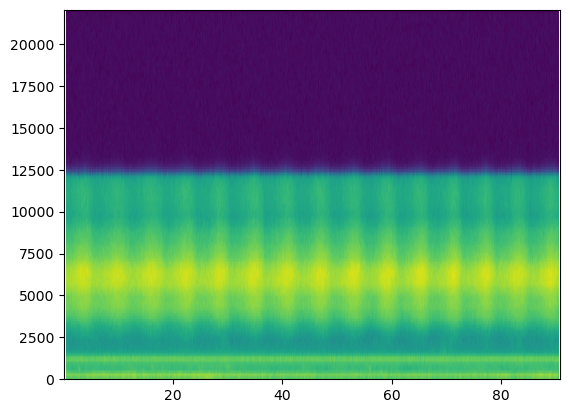

In [62]:
plt.specgram(x[:,0],Fs=sr,vmax=-50,vmin=-150);plt.show()

In [63]:
#spect export missing...

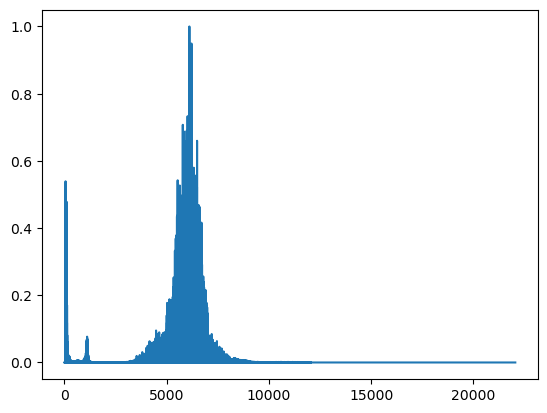

In [64]:
f,S=signal.periodogram(x[:,0],fs=sr);plt.plot(f,S/np.max(S));plt.show()


In [65]:
f2=signal.decimate(f,int(len(f)/5000))
S2=signal.decimate(S,int(len(f)/5000))

In [66]:
exportPgfplots("period",f2/1000,S2/np.max(S2),xlabel="Frequency (kHz)",ylabel="Spectral Power (a.u.)")

In [77]:
def downsample(values,factor):
    buffer_ = deque([],maxlen=factor)
    downsampled_values = []
    for i,value in enumerate(values):
        buffer_.appendleft(value)
        if (i-1)%factor==0:
            #Take max value out of buffer
            # or you can take higher value if their difference is too big, otherwise just average
            downsampled_values.append(max(buffer_))
    return np.array(downsampled_values)

y=x[:,0]
t=np.linspace(0,len(y)*1/sr,len(y))
y2=downsample(y**2,500)
t2=downsample(t,500)
print(len(t2))

8016


In [84]:
exportPgfplots("timesignal",t2,y2/np.max(y2),xlabel="Time (s)",ylabel="Power (a.u.)")

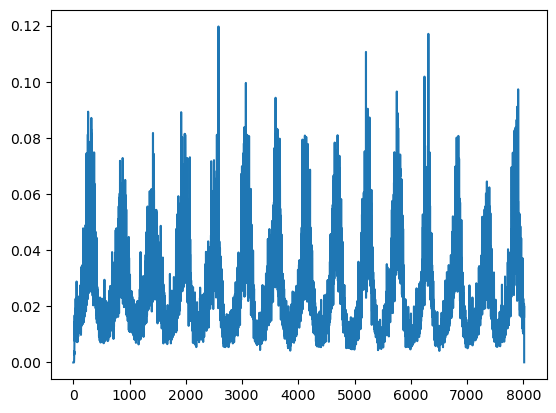

In [85]:
plt.plot(y2)

In [51]:
t2

array(<generator object take at 0x7f2ac917d840>, dtype=object)